## 캐글코리아 타이타닉 튜토리얼
**[링크](https://kaggle-kr.tistory.com/17?category=868316)**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5) #필자가 항상 쓰는 방법.
# matplotlib 의 기본 scheme 말고 seaborn scheme 을 세팅하고, 일일이
# graph 의 font size 를 지정할 필요 없이 seaborn 의 font_scale 을 사용하면
# 편합니다.
import missingno as msno

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 1. Dataset 확인

In [2]:
df_train = pd.read_csv("../input/titanic_train.csv")
df_test = pd.read_csv("../input/titanic_test.csv")

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


- 종속변수: Survived (생존 1, 사망 0)
- 독립변수
    - **Pclass**(티켓의 클래스. 1,2,3등석)
    - sex(성별. male or female)
    - **Age**(나이. int)
    - **sibSp**(함께 탑승한 형제 or 배우자 수, int)
    - **parch**(함께 탑승한 부모 or 아이의 수, int)
    - ticket(티켓 번호, alphabet + int)
    - **fare**(운임, float)
    - cabin(객실 번호, alphabet + int)
    - Embarked(탑승 항구, C = Cherbourg, Q = Queenstown, S = Southampton)
- 이 중에서
    - feature(양적 변수 말하는 듯) -> Pclass, Age, SibSp, Parch, Fare
    - target label -> Survived

In [27]:
df_train.corr()
# Survived와 상관관계 있는 양적 변수: Pclass, Fare 정도
# 아래(EDA)에서 범주형 변수와의 관련성 확인

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,0.012658
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225
Fare,0.012658,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000


In [8]:
# 각 feature가 가진 통계치. feature 중 Age만 714개 -> null이 있음
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
df_test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


### 1.1 Null data check

In [18]:
# format -> {:>10} 용법 알고 가기!!
for col in df_train.columns:
    msg = "column: {:>10}\t Percent of NaN value: {:.2f}%".format(
    col, 100 * (df_train[col].isnull().sum() / df_train[col].shape[0]))
    print(msg)

column: PassengerId	 Percent of NaN value: 0.00%
column:   Survived	 Percent of NaN value: 0.00%
column:     Pclass	 Percent of NaN value: 0.00%
column:       Name	 Percent of NaN value: 0.00%
column:        Sex	 Percent of NaN value: 0.00%
column:        Age	 Percent of NaN value: 19.87%
column:      SibSp	 Percent of NaN value: 0.00%
column:      Parch	 Percent of NaN value: 0.00%
column:     Ticket	 Percent of NaN value: 0.00%
column:       Fare	 Percent of NaN value: 0.00%
column:      Cabin	 Percent of NaN value: 77.10%
column:   Embarked	 Percent of NaN value: 0.22%


In [20]:
for col in df_test.columns:
    msg = 'column: {:>10}\t Percent of NaN value: {:.2f}%'.format(
    col, 100 * (df_test[col].isnull().sum() / df_test[col].shape[0]))
    print(msg)

column: PassengerId	 Percent of NaN value: 0.00%
column:     Pclass	 Percent of NaN value: 0.00%
column:       Name	 Percent of NaN value: 0.00%
column:        Sex	 Percent of NaN value: 0.00%
column:        Age	 Percent of NaN value: 20.57%
column:      SibSp	 Percent of NaN value: 0.00%
column:      Parch	 Percent of NaN value: 0.00%
column:     Ticket	 Percent of NaN value: 0.00%
column:       Fare	 Percent of NaN value: 0.24%
column:      Cabin	 Percent of NaN value: 78.23%
column:   Embarked	 Percent of NaN value: 0.00%


- train, test 둘 다 Age, Cabin(객실 번호)가 null
- train에선 Embarekd(탑승 항구) 중 0.22%가 null

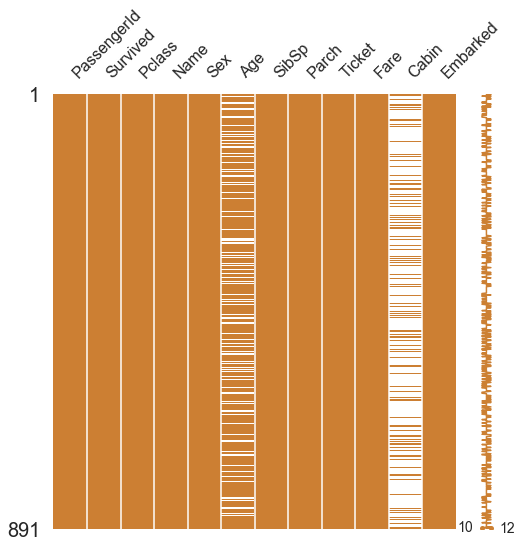

In [23]:
# msno 라이브러리 -> null data의 존재를 더 쉽게 볼 수 있음
# 여기서 color 값들은 RGB.
# 각 row에서 null 여부를 보기
msno.matrix(df=df_train, figsize=(8, 8), color=(0.8, 0.5, 0.2))

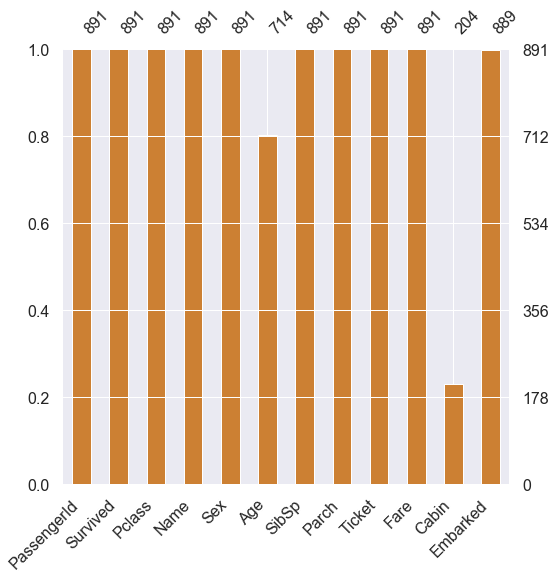

In [26]:
# null 아닌 비율과 숫자 보기
msno.bar(df=df_train, figsize=(8, 8), color=(0.8, 0.5, 0.2))

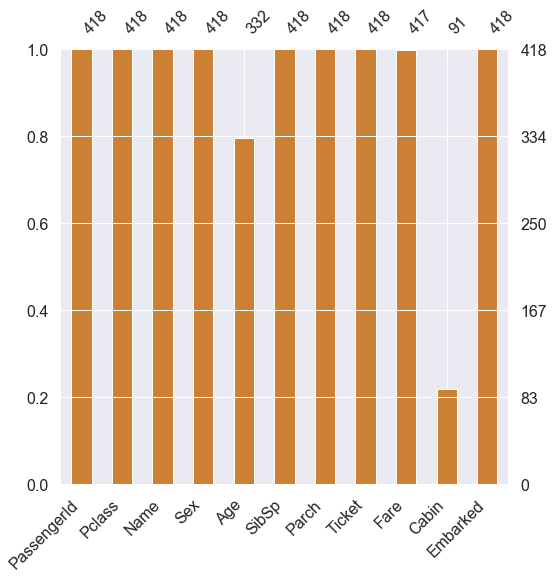

In [4]:
msno.bar(df=df_test, figsize=(8, 8), color=(0.8, 0.5, 0.2))

### 1.2 Target label 확인
- target label(survived)이 어떤 분포를 가지고 있는지 확인해야 함
- 지금 같은 binary classification 문제에서, 1과 0의 분포에 따라 모델의 평가 방법이 달라질 수 있음

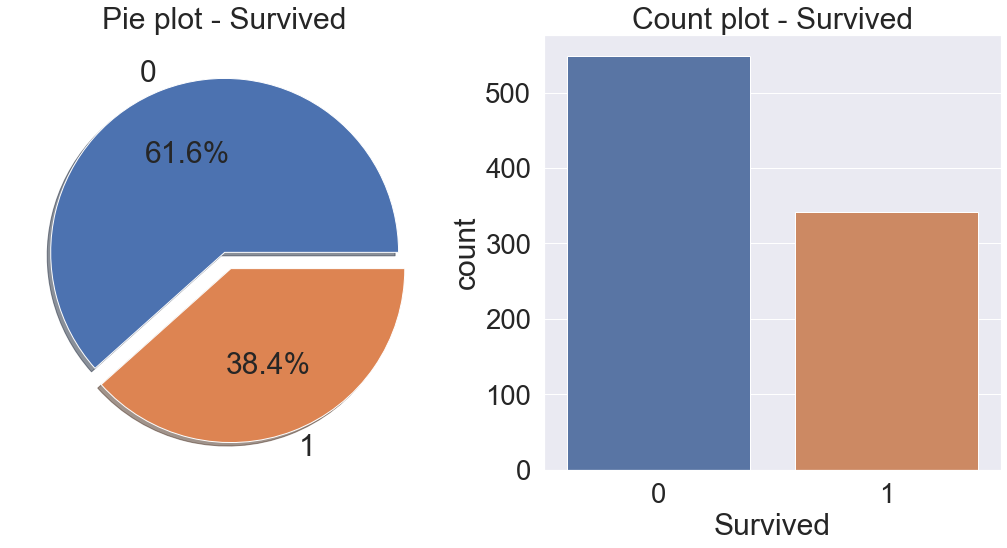

In [37]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

# 1. pie plot
df_train['Survived'].value_counts().plot.pie(
explode=[0, 0.1], autopct='%1.1f%%', ax=ax[0], shadow=True, fontsize=30)
ax[0].set_title('Pie plot - Survived')
ax[0].set_ylabel('')
# 2. count plot
sns.countplot('Survived', data=df_train, ax=ax[1])
ax[1].set_title('Count plot - Survived')

plt.show()

- target label의 분포가 제법 균일(balanced)함. 62% vs 38%
- 불균일한 경우, ex: 1이 99%인 경우 모두 1로 예측해도 정확도가 99%가 됨.
- 지금은 그렇지 않으니 계속함

## 2. EDA
### 2.1 Pclass(티켓 클래스. 1,2,3등석)
- 카테고리이면서, 순서가 있음
- Pclass에 따른 생존률의 차이 -> groupby나 pivot 메소드 사용

In [42]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).count()

,Survived
Pclass,
1,216
2,184
3,491


In [43]:
df_train[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).sum()
# Pclass 1의 경우, 216명 중 총 합(136)이 생존자 수가 됨

,Survived
Pclass,
1,136
2,87
3,119


In [48]:
#좀더 수월하게 보기 -> pd.crosstab : 이걸 컬러로 보기
pd.crosstab(df_train['Pclass'], df_train['Survived'], 
            margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Pclass,,,
1,80,136,216
2,97,87,184
3,372,119,491
All,549,342,891


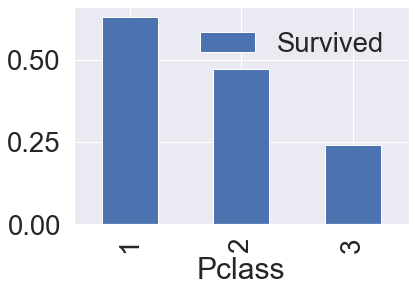

In [5]:
# Pclass별 그룹별 생존율을 생존률 내림차순으로 보기
df_train[['Pclass', 'Survived']].groupby(['Pclass'],
as_index=True).mean().sort_values(by='Survived', ascending=False).plot.bar()

1번 클래스가 생존률이 높음

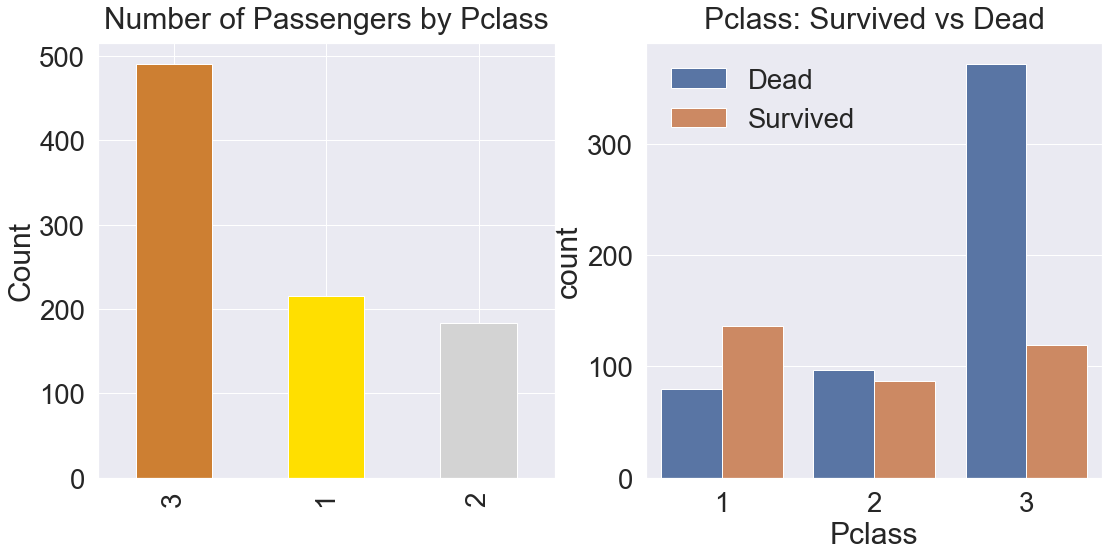

In [16]:
# 특정 label에 따른 개수 확인하기
y_position = 1.02 #제목과 plot 사이의 여백 조정
f, ax = plt.subplots(1, 2, figsize=(18, 8))

# 1. Pclass의 value_counts
df_train['Pclass'].value_counts().plot.bar(color=['#CD7F32',
'#FFDF00', '#D3D3D3'], ax=ax[0])
ax[0].set_title('Number of Passengers by Pclass', y=y_position)
ax[0].set_ylabel('Count')

# 2. Pclass별 Survived vs Dead
sns.countplot('Pclass', hue='Survived', data=df_train, ax=ax[1]) #sns는 data.column을 이렇게 쓰는 듯
ax[1].set_title('Pclass: Survived vs Dead', y=y_position)
ax[1].legend(['Dead','Survived']) #0, 1을 확인하기 쉽게 생존, 사망으로 바꿔 줌
plt.show()

- 클래스가 높을수록 생존 확률이 높은 것을 확인할 수 있음.
- 따라서 모델 세울 때 이 feature를 사용하는 것이 좋을 것이라고 판단 가능

### 2.2 Sex

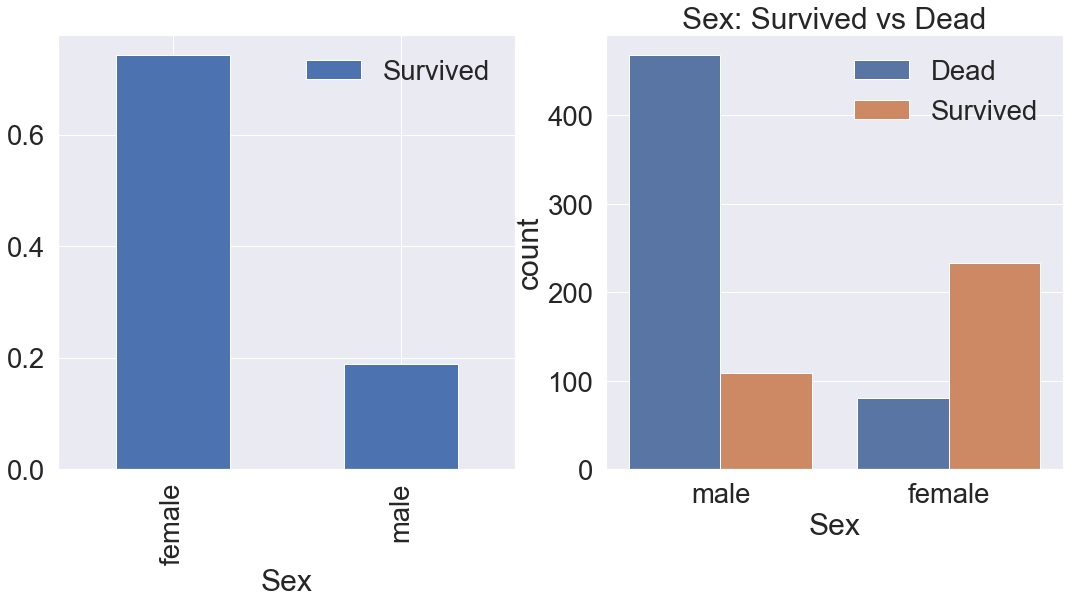

In [21]:
f, ax = plt.subplots(1, 2, figsize=(18, 8))

# 1. Sex별 생존율(mean) 보기
df_train[['Sex', 'Survived']].groupby(['Sex'],
as_index=True).mean().plot.bar(ax=ax[0])

# 2. Sex별 Survived vs Dead
sns.countplot('Sex', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('Sex: Survived vs Dead')
ax[1].legend(['Dead','Survived']) #0, 1을 확인하기 쉽게 생존, 사망으로 바꿔 줌
plt.show()

여자가 생존확률 높음

In [23]:
df_train[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(
by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [26]:
# crosstab에서 margins=False 하면 합계 칼럼(All)은 안 나옴
pd.crosstab(df_train['Sex'], df_train['Survived'], 
            margins=True).style.background_gradient(cmap='summer_r')

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


Sex 도 예측 모델에 쓰일 중요한 feature임을 알 수 있음

### 2.3 Sex, Pclass 같이 보기
- 두 변수에 관하여 생존이 어떻게 달라지는지 확인
- seaborn의 factorplot 이용

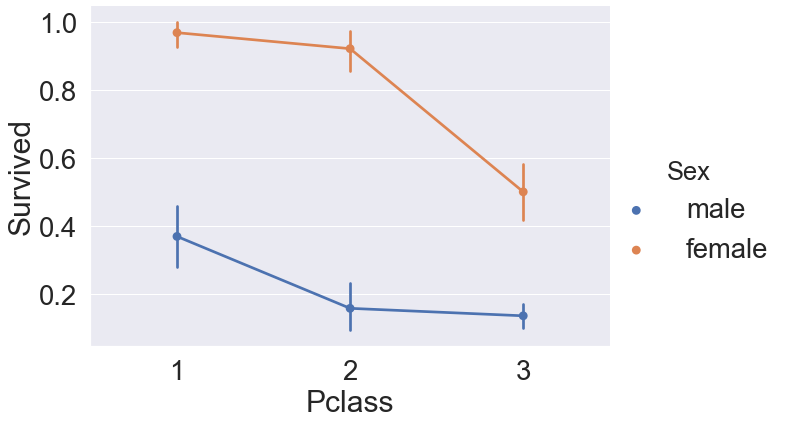

In [30]:
sns.factorplot('Pclass', 'Survived', hue='Sex', 
               data=df_train, size=6, aspect=1.5)

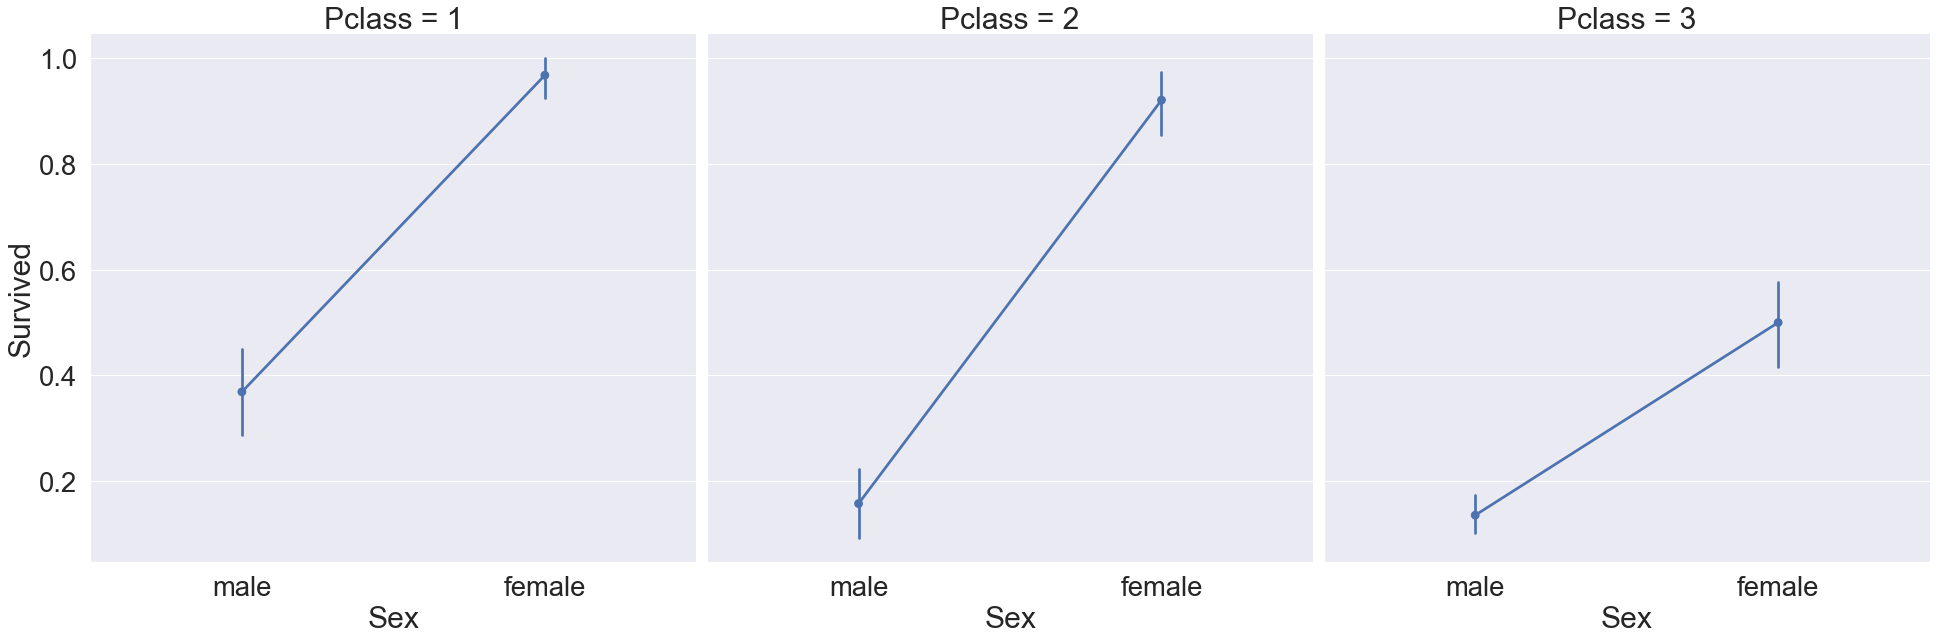

In [38]:
# hue(색조로 구분) 대신 column으로
sns.factorplot('Sex', 'Survived', col='Pclass', 
               data=df_train, satureation=.5, size=9, aspect=1)
# aspect는 y축 늘린 비율(작을수록 길어짐)

- 모든 Pclass에서 female이 살 확률이 male보다 높음
- 남,여 상관 없이 클래스가 높을수록 살 확률 높음

### 2.4 Age

In [39]:
print('제일 나이 많은 탑승객: {:.1f} Years'.format(df_train['Age'].max()))
print('제일 어린 탑승객: {:.1f} Years'.format(df_train['Age'].min()))
print('탑승객 평균 나이: {:.1f} Years'.format(df_train['Age'].mean()))

제일 나이 많은 탑승객: 80.0 Years
제일 어린 탑승객: 0.4 Years
탑승객 평균 나이: 29.7 Years


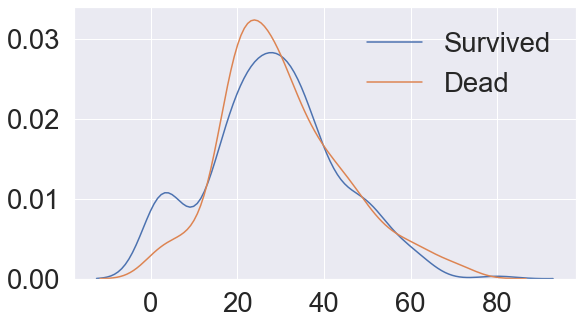

In [45]:
# 생존에 따른 Age의 분포 그래프 보기
# 같은 그래프에 겹쳐서 그리려면 이렇게 하면 됨!!
fig, ax = plt.subplots(1, 1, figsize = (9,5))
sns.kdeplot(df_train[df_train['Survived'] == 1]['Age'], ax=ax)
sns.kdeplot(df_train[df_train['Survived'] == 0]['Age'], ax=ax)
plt.legend(['Survived', 'Dead'])
plt.show()

생존자 중 나이 어린 경우가 많음을 볼 수 있음(5세 정도에서 peak)

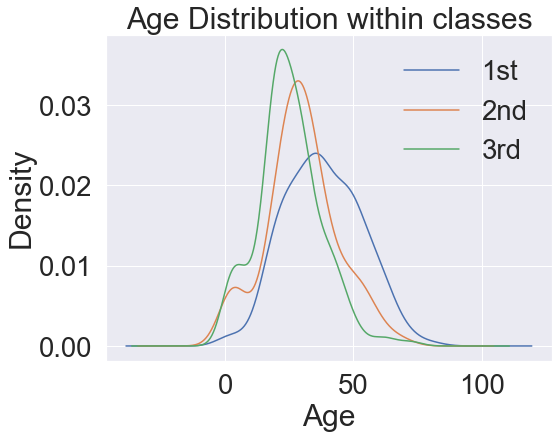

In [49]:
# Age distribution within classes
plt.figure(figsize = (8,6))
# 와 이렇게도 데이터 편집이 된다고?? 같은 코드여서 그런 듯.
# Age로 이미 걸렀으면 Pclass로 필터링이 안될 것 같은데 됨.
for pclass in range(1, 4):
    df_train['Age'][df_train['Pclass'] == pclass].plot(kind='kde')
    
plt.xlabel('Age')
plt.title('Age Distribution within classes')
plt.legend(['1st', '2nd', '3rd'])

- class가 높을 수록 나이 많은 사람의 비중이 커짐
- 나이대가 변하면서 생존률이 어떻게 되는지 보기
- **나이 범위**를 점점 넓혀가며 생존률 확인해 보기

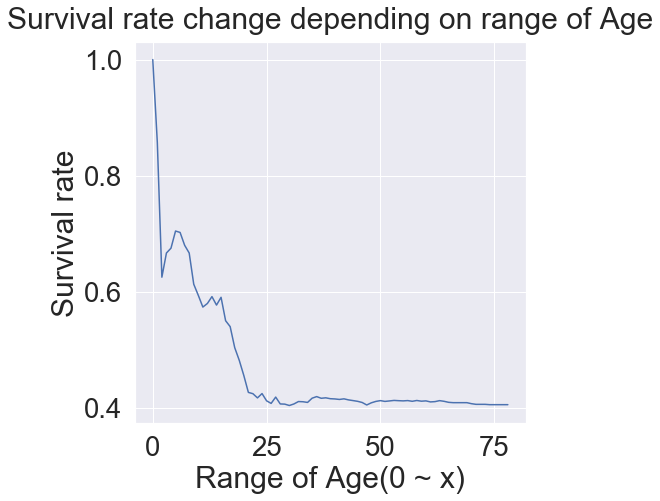

In [51]:
cum_survival_ratio = []
for i in range(1, 80):
    cum_survival_ratio.append(
    df_train[df_train['Age'] < i]['Survived'].sum() /
    len(df_train[df_train['Age'] < i]['Survived']))

plt.figure(figsize = (7, 7))
plt.plot(cum_survival_ratio)
plt.title('Survival rate change depending on range of Age', y=1.02)
plt.ylabel('Survival rate')
plt.xlabel('Range of Age(0 ~ x)')
plt.show()

- 나이가 어릴수록 생존률 높은 것 확인할 수 있음
- 나이가 중요한 feature로 쓰일 수 있음을 확인

### 2.5 Pclass, Sex, Age 같이
- 세 변수 모두 Survived에 영향
- 이 모두에 대해서 보려면, seaborn의 violinplot 활용
- x축은 나눠서 보려는 변수(Pclass, Sex), y축은 보고 싶어하는 분포(Age)

f, ax = plt.subplots(1, 2, figsize = (18, 8))

#1. Pclass(x) - Age(y)
sns.violinplot('Pclass', 'Age', hue='Survived', data=df_train,
              scale='count', split=True, ax=ax[0])
ax[0].set_title('Pclass and Age vs Survived')
ax[0].set_yticks(range(0, 110, 10)) # y축 범위 설정
sns.violinplot('Sex', 'Age', hue='Survived', data=df_train,
              scale='count', split=True, ax=ax[1])
#split=False 하면 hue 변수 기준으로 따로 그림

#2. Sex - Age
ax[1].set_title('Sex and Age vs Survived')
ax[1].set_yticks(range(0, 110, 10))
plt.show()

- 왼쪽 그림: 생존만 봤을 때 모든 클래스에서 나이가 어릴수록 많이 생존
- 오른쪽 그림: 여자가 많이 생존
--> 여성과 아이를 먼저 챙긴 것을 확인할 수 있음

### 2.6 Embarked(탑승 항구)
- 탑승 항구에 따른 생존 확률 보기

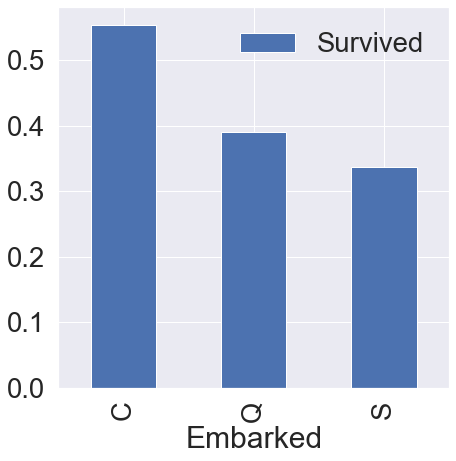

In [7]:
f, ax = plt.subplots(1, 1, figsize = (7, 7))
df_train[['Embarked', 'Survived']].groupby('Embarked').mean().sort_values(
by='Survived', ascending=False).plot.bar(ax=ax)

- 탑승 항구별로 조금씩 생존률 차이가 있음
- 모델에 얼마나 큰 영향을 미칠지는 모르겠지만, 일단 사용
- 모델 생성 후 feature들이 얼마나 중요한 역할 했는지 확인 가능!

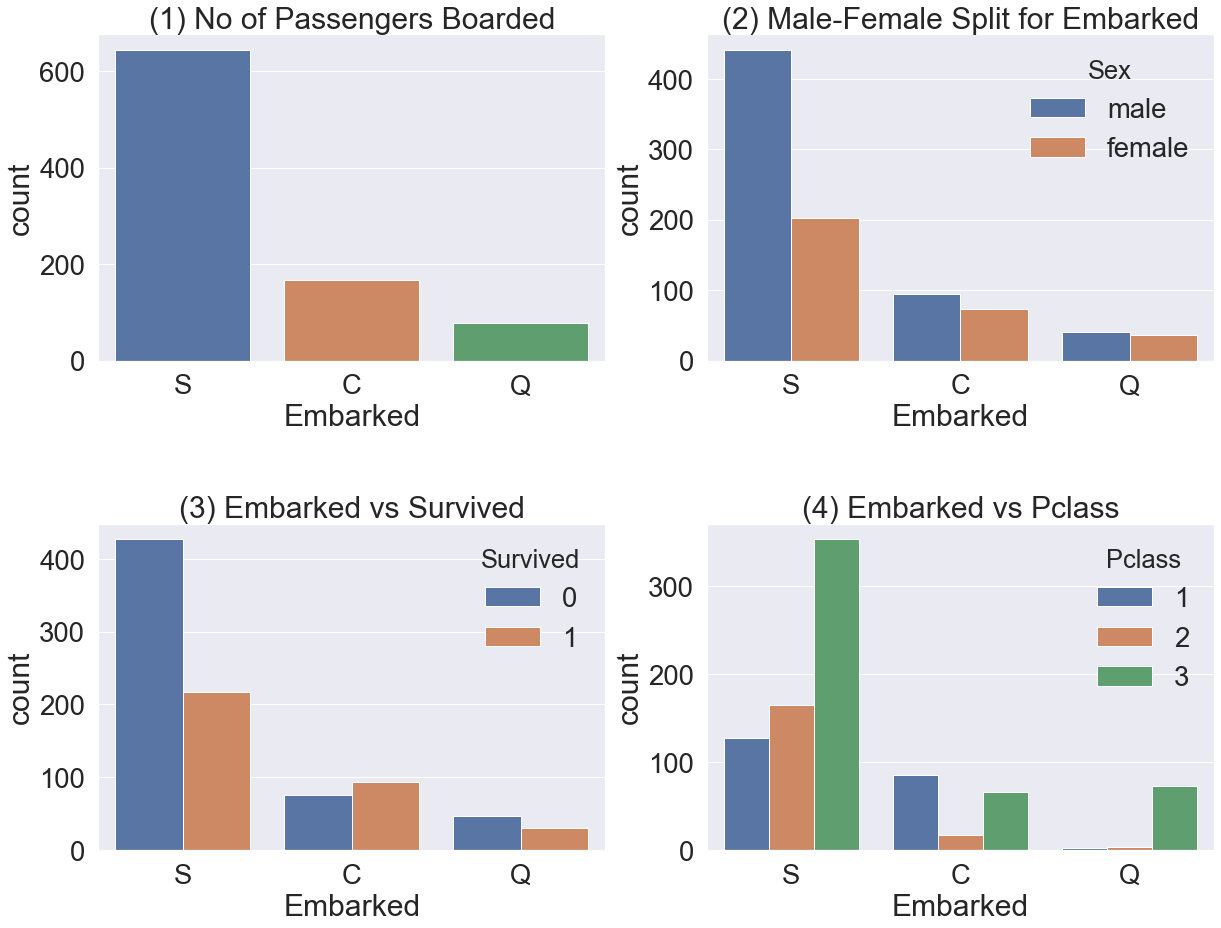

In [14]:
f, ax = plt.subplots(2, 2, figsize=(20, 15))
# 그룹별 count 보기 -> sns.countplot
sns.countplot('Embarked', data=df_train, ax=ax[0,0])
ax[0,0].set_title('(1) No of Passengers Boarded')
sns.countplot('Embarked', hue='Sex', data=df_train, ax=ax[0,1])
ax[0,1].set_title('(2) Male-Female Split for Embarked')
sns.countplot('Embarked', hue='Survived', data=df_train, ax=ax[1,0])
ax[1,0].set_title('(3) Embarked vs Survived')
sns.countplot('Embarked', hue='Pclass', data=df_train, ax=ax[1,1])
ax[1,1].set_title('(4) Embarked vs Pclass')

plt.subplots_adjust(wspace=0.2, hspace=0.5) #subplot 간의 가로,세로 간격인듯
plt.show()

- 항구별 생존 비율: C > Q > S
- S 항구 탑승객의 경우 3등석 비율이 많아 생존 비율이 적은 것으로 보임
    - 위에서 Pclass별 생존율의 경우 1 > 2 > 3 이었음
- 반면 C 항구의 경우 1등석 비율이 상대적으로 많아 생존자가 사망자보다 많음
- 커널처럼 Figure별로 정리하기!!
    - Figure 1 -> 전체적으로 봤을 때 S에 가장 많은 사람이 탑승
    - Figure 2 -> C와 Q는 남녀 비율이 비슷하고, S는 남자가 많음(생존 확률이 낮은 것과 관련이 있나?
    - Figure 3 -> 생존 확률이 S의 경우 많이 낮음
    - Figure 4 -> Pclass로 split해서 보니 C가 생존 확률이 높은 건 클래스가 높은 사람이 많이 탔기 때문. S는 3등석이 많아 생존 확률이 낮음

### 2.7 Family - SibSp(형제 자매) + Parch(부모 자녀)
- 이걸 합하면 Family가 될 것. 합쳐서 분석해 보기

In [15]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 # 자신을 더하기
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

In [16]:
print('Maximum size of Family:', df_train['FamilySize'].max())
print('Minimum size of Family:', df_train['FamilySize'].min())

Maximum size of Family: 11
Minimum size of Family: 1


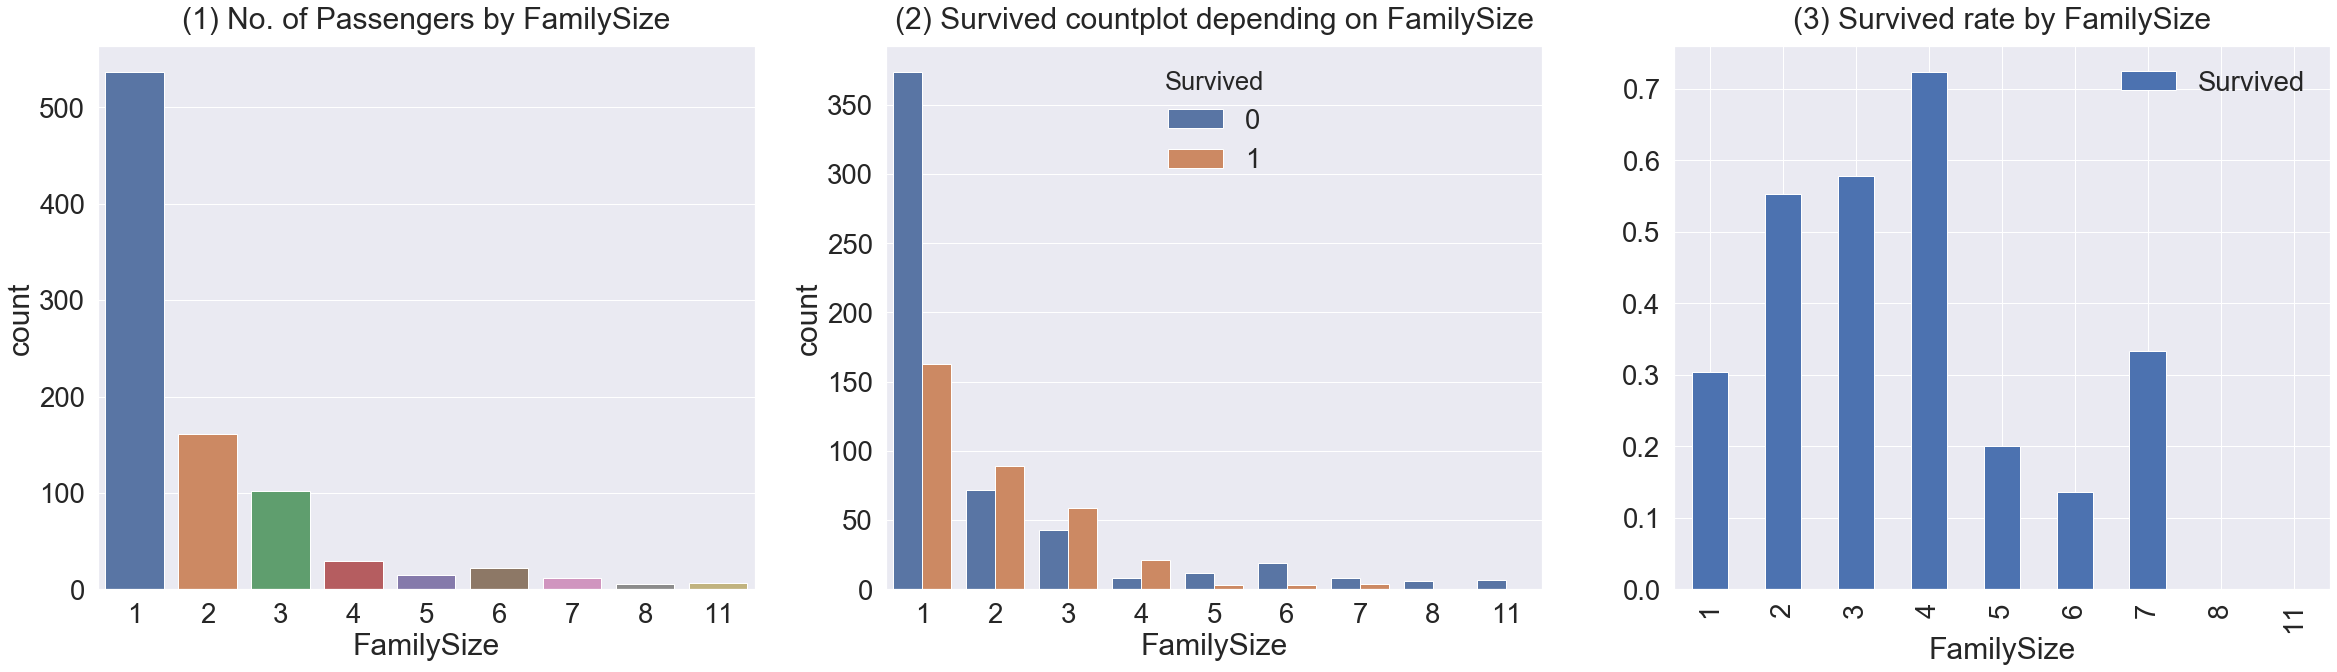

In [41]:
# FamilySize와 생존의 관계 보기
f, ax = plt.subplots(1, 3, figsize=(40, 10))
# 1. FamilySize 별 count
sns.countplot('FamilySize', data=df_train, ax=ax[0])
ax[0].set_title('(1) No. of Passengers by FamilySize', y=1.02)

# 2. FamilySize별 생존/사망 비교
sns.countplot('FamilySize', hue='Survived', data=df_train, ax=ax[1])
ax[1].set_title('(2) Survived countplot depending on FamilySize', y=1.02)

# 3. 
# groupby -> as_index=False 하면 FamilySize가 index가 아닌 열로 나옴
df_train[['FamilySize', 'Survived']].groupby('FamilySize',
as_index=True).mean().plot.bar(ax = ax[2])
#이건 mean().sort_values(by='FamilySize', ascending=False) 안하는 게 좋을 듯
ax[2].set_title('(3) Survived rate by FamilySize', y=1.02)

plt.subplots_adjust(wspace=0.2) #한 줄이니까 hspace는 안해도 되지 않나?
plt.show()

Figure
- 1) 가족크기가 1~11까지 있으며 가족 수가 많을수록 count가 적음
- 2,3) 가족이 4명인 경우가 가장 생존 확률이 높음. 그 이상은 생존 확률이 낮아짐. 2~4명이 가장 높음

In [35]:
# 확인용
df_train[['FamilySize', 'Survived']].groupby('FamilySize',
as_index=True).mean()

,Survived
FamilySize,
1,0.303538
2,0.552795
3,0.578431
4,0.724138
5,0.200000
6,0.136364
7,0.333333
8,0.000000
11,0.000000


### 2.8 Fare(탑승 요금, 연속형 feature)

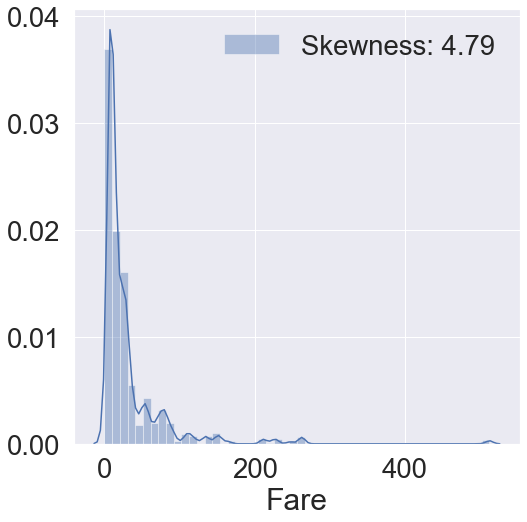

In [51]:
# histogram 그리기
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness: {:.2f}'.format(
df_train['Fare'].skew()), ax=ax)
g.legend(loc='best') #best 위치에 알아서 넣어줌?

- 분포가 매우 비대칭(high skewness). 이대로 모델에 넣는다면 잘못 학습할 수 있음. 몇 개 없는 outlier에 대해서 너무 민감하게 반응하여, 실제 예측시 좋지 못한 결과를 부를 수 있음
- outlier의 영향 줄이기 위해, Fare에 log 취함
- 또한 Fare는 null 값이 있음. NaN value를 평균값으로 치환

In [69]:
df_test.loc[df_test['Fare'].isnull(), 'Fare'] = df_test['Fare'].mean()

# Fare = 0일 경우 log값이 오류 남 -> 예외처리 해줌
# map이든 apply 이든 상관 없을 듯
df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

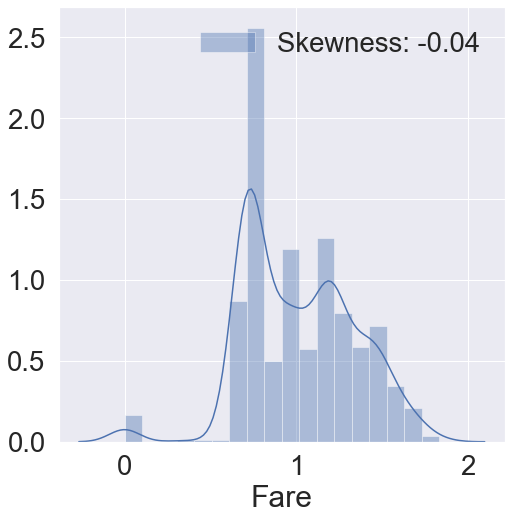

In [68]:
fig, ax = plt.subplots(1, 1, figsize = (8, 8))
g = sns.distplot(df_train['Fare'], color='b', label='Skewness: {:.2f}'.format(
df_train['Fare'].skew()), ax=ax)
g.legend(loc='best')

- log 취하니 비대칭성이 많이 사라짐. Skewness도 감소

### 2.9 Cabin(객실번호, alphabet + int)
- null이 약 80%인 변수
- 생존에 영향을 미칠 중요한 정보를 얻어내기가 쉽지 않으므로, 세우려는 모델에 포함시키지 않음

In [70]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,-0.380379,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,0.372137,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,-0.318060,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,0.321586,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,-0.307761,NaN,S,1


### 2.10 Ticket(티켓번호, alphabet + int)
- null은 없음
- string data이므로 어떤 작업을 해 주어야 모델에 사용 가능. 아이디어가 필요!
- value_counts()를 변수로? 같이 구입한 그룹일 것.

In [92]:
df_train['Ticket'].value_counts().head()

347082      7
1601        7
CA. 2343    7
3101295     6
347088      6
Name: Ticket, dtype: int64

In [73]:
# 그럼 걍 티켓번호 대신 FamilySize 쓰면 되지 않나?
print(df_train[df_train['Ticket'] == '347082'].shape[0]) #이건 value_counts 값과 같음

7


In [91]:
# Ticket_count 칼럼 -> 같은 티켓이 몇 장 있는지
df_train['Ticket_count'] = df_train['Ticket'].value_counts()[df_train['Ticket']].values
df_train.corr() # FamilySize와 Ticket_count -> corr 0.75 높은 상관관계 가짐.

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,Ticket_count
PassengerId,1.000000,-0.005007,-0.035144,0.036847,-0.057527,-0.001652,-0.000282,-0.040143,0.003355
Survived,-0.005007,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.324005,0.016639,0.038247
Pclass,-0.035144,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.734494,0.065997,-0.002633
Age,0.036847,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.123139,-0.301914,-0.253507
SibSp,-0.057527,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.357022,0.890712,0.661622
Parch,-0.001652,0.081629,0.018443,-0.189119,0.414838,1.000000,0.368883,0.783111,0.593076
Fare,-0.000282,0.324005,-0.734494,0.123139,0.357022,0.368883,1.000000,0.428300,0.538659
FamilySize,-0.040143,0.016639,0.065997,-0.301914,0.890712,0.783111,0.428300,1.000000,0.748487
Ticket_count,0.003355,0.038247,-0.002633,-0.253507,0.661622,0.593076,0.538659,0.748487,1.000000


In [99]:
print("FamilySize와 Ticket_count가 같은 비율: {:.1f}%".format(
100 * df_train[df_train['FamilySize'] == df_train['Ticket_count']].shape[0] / df_train.shape[0]))

FamilySize와 Ticket_count가 같은 비율: 67.7%
